# UTK Face Age and Gender Prediction with Custom Model

In [ ]:
!pip install poutyne
!pip install torchsummary

In [1]:
import os
import tarfile
import urllib.request
import re
import json

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.special import softmax
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder, VisionDataset
from torchvision.utils import make_grid

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, BatchMetric
import tarfile
from torchsummary import summary
from PIL import Image

## Download and prepare the UTK Face dataset

In [2]:
set_seeds(42)
base_path = './datasets/utk_faces'
tar_file_name = 'utk_face.tar.gz'
base_image_path = os.path.join(base_path, 'images')
download_url = 'https://drive.google.com/uc?export=download&id=0BxYys69jI14kYVM3aVhKS1VhRUk&alt=media&confirm=t'

#### Download and extract dataset images
Dataset: https://susanqq.github.io/UTKFace

In [3]:
def download_and_extract_dataset(base_path, extract_path, file_name, url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    tar_filename = os.path.join(base_path, file_name)

    print(f'Downloading dataset to {tar_filename} ...')
    urllib.request.urlretrieve(url, tar_filename)
    print('Extracting archive...')
    with tarfile.open(tar_filename, "r") as tar:
        tar.extractall(extract_path)
    
download_and_extract_dataset(base_path, base_image_path, tar_file_name, download_url)    

Extracting archive...


#### Setup training constants

In [4]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

batch_size = 32
image_size = 48
n_gender_classes = 2
n_emotion_classes = 7
gender_classes = ['female', 'male']

#### Create datasets and image transforms

In [5]:
class FaceAgeGenderImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
            
        filename = os.path.basename(path)
        age, gender, race, _ = filename.split('_')
        gender = 1 - int(gender)

        return sample, (torch.tensor([float(age)]), gender)

In [6]:
normalize_transform = transforms.Compose(
    [        
        transforms.Resize((image_size, image_size)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.25))
    ]
)

re_valid_file_name = re.compile('\d+_\d_\d_.*')

face_age_gender_dataset = FaceAgeGenderImageFolder(
    base_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.') and re_valid_file_name.match(os.path.basename(path)),
)

#### Dataset sizes and classes

In [7]:
print(f'dataset size: {len(face_age_gender_dataset)}')

dataset size: 23705


#### Example face images

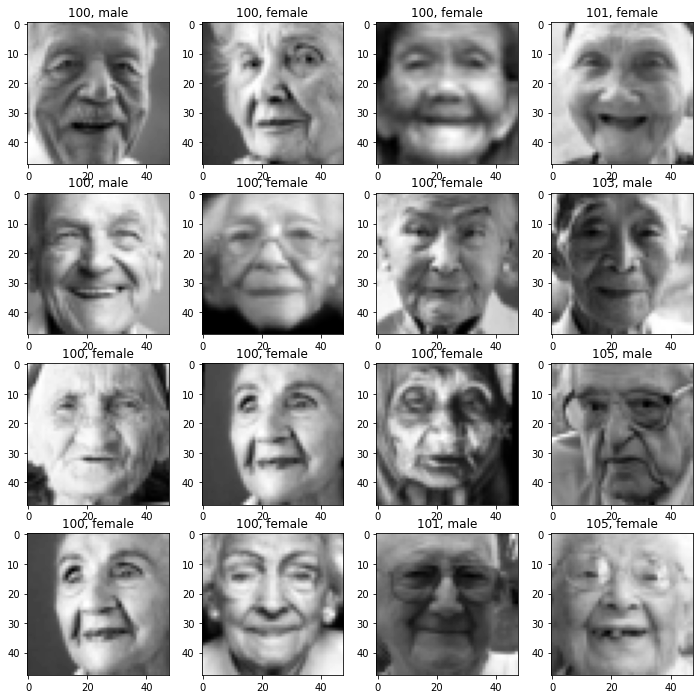

In [8]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    for i, (image, (age, gender)) in enumerate(dataset):
        ax[i % 4, i // 4].set_title(f'{int(age[0])}, {gender_classes[gender]}')
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0), cmap='gray')
        if i >= 15:
            break
            
show_batch(face_age_gender_dataset)          

## Create CNN model for facial emotion recognition and classification

In [9]:
class AgeGenderEmotionNetork(nn.Module):
    def __init__(self):
        super(AgeGenderEmotionNetork, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='same')    
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.bn_conv1 = nn.BatchNorm2d(64)
        self.dropout_conv1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout2d(0.25)        
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.dropout_conv4 = nn.Dropout2d(0.25)        
        
        self.conv5_age = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_age = nn.BatchNorm2d(512)    
        self.dropout_conv5_age = nn.Dropout2d(0.25)
        
        self.conv5_gender = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_gender = nn.BatchNorm2d(512)    
        self.dropout_conv5_gender = nn.Dropout2d(0.25)   
        
        self.conv5_emotion = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same')
        self.bn_conv5_emotion = nn.BatchNorm2d(512)    
        self.dropout_conv5_emotion = nn.Dropout2d(0.25)           
        
        self.fc1 = nn.Linear(4608, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn_fc2 = nn.BatchNorm1d(512)
        self.dropout_fc2 = nn.Dropout(0.25)
        
        flatten_length = 4608
        self.fc1_age = nn.Linear(flatten_length, 512)
        self.bn_fc1_age = nn.BatchNorm1d(512)
        self.dropout_fc1_age = nn.Dropout(0.25)
        
        self.fc1_gender = nn.Linear(flatten_length, 512)
        self.bn_fc1_gender = nn.BatchNorm1d(512)
        self.dropout_fc1_gender = nn.Dropout(0.25)
        
        self.fc1_emotion = nn.Linear(flatten_length, 512)
        self.bn_fc1_emotion = nn.BatchNorm1d(512)
        self.dropout_fc1_emotion = nn.Dropout(0.25)
        
        self.fc2_age = nn.Linear(512, 256)
        self.bn_fc2_age = nn.BatchNorm1d(256)
        self.dropout_fc2_age = nn.Dropout(0.25)    
        
        self.fc2_gender = nn.Linear(512, 256)
        self.bn_fc2_gender = nn.BatchNorm1d(256)
        self.dropout_fc2_gender = nn.Dropout(0.25)
        
        self.fc2_emotion = nn.Linear(512, 256)
        self.bn_fc2_emotion = nn.BatchNorm1d(256)
        self.dropout_fc2_emotion = nn.Dropout(0.25)
        
        self.fc3_out_age = nn.Linear(256, 1)
        self.fc3_out_gender = nn.Linear(256, n_gender_classes)
        self.fc3_out_emotion = nn.Linear(256, n_emotion_classes)        
        
    def forward(self, input):    
        output = F.relu(self.conv1(input))      
        output = F.relu(self.conv2(output))
        output = self.bn_conv1(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv1(output)
        
        output = F.relu(self.conv3(output))
        output = self.bn_conv3(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv3(output)
        
        output = F.relu(self.conv4(output))
        output = self.bn_conv4(output)        
        output = self.maxpool(output)    
        output = self.dropout_conv4(output)
        
        output_age = F.relu(self.conv5_age(output))
        output_age = self.bn_conv5_age(output_age)
        output_age = self.maxpool(output_age)            
        output_age = self.dropout_conv5_age(output_age) 
        
        output_gender = F.relu(self.conv5_gender(output))
        output_gender = self.bn_conv5_gender(output_gender)
        output_gender = self.maxpool(output_gender)            
        output_gender = self.dropout_conv5_gender(output_gender)  
        
        output_emotion = F.relu(self.conv5_emotion(output))
        output_emotion = self.bn_conv5_emotion(output_emotion)
        output_emotion = self.maxpool(output_emotion)            
        output_emotion = self.dropout_conv5_emotion(output_emotion)          
        
        # Flattening process
        output_age = torch.flatten(output_age, start_dim=1)
        output_gender = torch.flatten(output_gender, start_dim=1)
        output_emotion = torch.flatten(output_emotion, start_dim=1)
                
        output_age = F.relu(self.fc1_age(output_age))
        output_age = self.bn_fc1_age(output_age)
        output_age = self.dropout_fc1_age(output_age)
        
        output_gender = F.relu(self.fc1_gender(output_gender))
        output_gender = self.bn_fc1_gender(output_gender)
        output_gender = self.dropout_fc1_gender(output_gender)   
        
        output_emotion = F.relu(self.fc1_emotion(output_emotion))
        output_emotion = self.bn_fc1_emotion(output_emotion)
        output_emotion = self.dropout_fc1_emotion(output_emotion)   
        
        output_age = F.relu(self.fc2_age(output_age))
        output_age = self.bn_fc2_age(output_age)
        output_age = self.dropout_fc2_age(output_age)        
        output_age = self.fc3_out_age(output_age)
        
        output_gender = F.relu(self.fc2_gender(output_gender))
        output_gender = self.bn_fc2_gender(output_gender)
        output_gender = self.dropout_fc2_gender(output_gender)        
        output_gender = self.fc3_out_gender(output_gender)
        
        output_emotion = F.relu(self.fc2_emotion(output_emotion))
        output_emotion = self.bn_fc2_emotion(output_emotion)
        output_emotion = self.dropout_fc2_emotion(output_emotion)        
        output_emotion = self.fc3_out_emotion(output_emotion)
        
        return output_age, output_gender, output_emotion
    
age_gender_emotion_netork = AgeGenderEmotionNetork().to(device)
print(summary(age_gender_emotion_netork, input_size=(1, image_size, image_size)))   

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
            Conv2d-2           [-1, 64, 48, 48]          18,496
       BatchNorm2d-3           [-1, 64, 48, 48]             128
         MaxPool2d-4           [-1, 64, 24, 24]               0
         Dropout2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
       BatchNorm2d-7          [-1, 128, 24, 24]             256
         MaxPool2d-8          [-1, 128, 12, 12]               0
         Dropout2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
        Dropout2d-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 51

## Use trained age, gender and emotion model to predict age and gender on UTK Face dataset

In [10]:
model = Model(
    age_gender_emotion_netork,
    None,
    None,
    device=device
)

model.load_weights('./saves/fer_faces_age_gender_emotion/best_epoch_61.ckpt')
utk_predictions = model.predict_dataset(face_age_gender_dataset, has_ground_truth=True, batch_size=256)

correct_count = 0
age_error = 0
for i, (image, (age, gender)) in enumerate(face_age_gender_dataset):        
        predicted_age = utk_predictions[0][i][0].astype(int) 
        
        gender_softmax = softmax(utk_predictions[1][i])
        predicted_gender = gender_softmax.argmax()
        
        age_error = age_error + abs(age - predicted_age)

        if predicted_gender == gender:
            correct_count = correct_count + 1
            
age_mean_abs_error = age_error[0] / len(face_age_gender_dataset)
gender_accuracy = correct_count / len(face_age_gender_dataset)

print(f'gender accuracy: {gender_accuracy}') 
print(f'age error: {age_mean_abs_error}')              

Prediction steps: 93 2m10.46s                                           
gender accuracy: 0.8990086479645645
age error: 8.2369966506958
